CSML1010 Group3 Course_Project - Feature Engineering

#### Import Libraries

In [4]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [5]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

#### Load Data

In [6]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [11]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

df_all

selfdialog_clean  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                      Hi, I'm looking to book a table for Korean fod. Ok, what area are you thinking about? Somewhere in Southern NYC, maybe the East Village? Ok, great.  There's Thursday Kitchen, it has great reviews. That's great. So I need a table for tonight at 7 pm for 8 people. We don't want to sit at the bar, but anywhere else is fine. They don't have any availability for 7 pm. What times are available? 5 or 8. Yikes, we can't do those times. Ok, do you have a second choice? Let me check. Ok. Lets try Boka, are they free for 8 people at 7? Yes. Great, let's book that. Ok great, are there any other requests? No, that's it, just book. Great, should I use your account you have open with them? Yes please. Great. You will get a confirmation to your phone soon.    
1                                                                                                                                                                                                                Hi I would like to see if the Movie What Men Want is playing here. Yes it's showing here would you like to purchase a ticket? Yes, for me and a friend so two tickets please Okay. What time is that moving playing today? That movie is showing at 4, 5, and 8pm. Okay. Is there anymore movies showing around 8pm Yes , showing at 8pm is Green Book. What is that about? It's about two men dealing with racisim. Oh, no can you recommend anything else? What do you like? Well I like movies that are funny. Like comedies? Well no I like action as well. Okay. How to train your dragon is playing at 8pm. Okay can i get two tickets for that ? So you want me to cancel the tickets for What men want ? Yes please. Okay, no problem. How much will this cost. You said two adult tickets? Yes. Okay, that will be $20.80 Okay. Anything else I can help you with ? Yes can i bring my own food to theater. No, sorry you have to purchase food in the lobby. Okay that is fine. Thank you enjoy your movie    
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           I want to watch avengers endgame where do you want to watch it at? at bangkok close the hotel I a currently staying sounds good, what time do you want to watch the movie? 8 o'clock how many tickets? two and should we use the account we already have with the movie theater? yes It seems they do not have any movie at that time let's watch another movie then what other movie do you want to watch let's watch how to train your dragon the newest one yes, that one I don't think that movie is playing at that time either so neither choices are playing at the time I want to watch I am afraid so  I am no longer interested in watching the movie very well, have a great day sir thank you you are welcome    
3                                                                                                                                                                                                                                                                                                                                                                                                             

Down sample to 1000 records.

In [8]:
print ((1000 * 1000)//7708)

129


In [15]:
# Get 50 per instruction_id then reduce to 1000
def sampling_k_elements(group, k=130):
    if len(group) < k:
        return group
    return group.sample(k)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to 1000
corpus_df = corpus_df.sample(n=1000, random_state=1)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    78
coffee-ordering-1     73
coffee-ordering-2     79
movie-finder          36
movie-tickets-1       80
movie-tickets-2       79
movie-tickets-3       76
pizza-ordering-1      70
pizza-ordering-2      81
restaurant-table-1    72
restaurant-table-2    73
restaurant-table-3    65
uber-lyft-1           71
uber-lyft-2           67
dtype: int64


selfdialog_clean  \
111                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         I need some auto service What do you need? I'm driving right now. I need all of my tires replaced. They feel funny. What garage should I look up. look up Intelligent Auto Solutions I'll do that now Tell them I need to be seen immediatly. right away what is the make of your car? It's a chevy astro-van 1991 phone number? (999)555-5521. the name is Davis, but you already know that. I'll see what i can do what do they say? They can't see you 'til tomorrow What about later tonight? You can arrive at eight-thirty, but don't be late. They'll replace your tires Do they have the size? Yes, I asked them please confirm the initial fee Intelligent auto solutions at eight-thirty tonight. They'll put on new tires, four of them of the correct size. It will be 475 dollars. They're having a sale. okay!    
126   hello Amy, I need to book an appointment to get my car checked out. Hello James. Where is your car to be picked up at, and where would you like me to take it to have it checked out? I will leave it parked outside my office . I would like you to take it to Intelligent Auto Solutions. OK, I will set up an appointment with Intelligent Auto Solutions. Where can I find the keys? I have left the keys in the sun visor. The vehicle door code is 47660 Very good. What shall I tell the shop about the condition of the car? Yes, the car has a squealing noise. Alright, I will let them know. They said the more specific the better. Is there any other details you can tell me about the problem? Yes, the noise Is coming coming from the driver side front wheel. OK. I will make note of that. Also, it is only noticeable at speeds above 35 miles per hour.  Alright, I will contact the shop. Is there a time that works best for me to schedule the appointment.  Yes. I will be leaving it at my office on Thursday, the sooner I can get it back the better. OK. I have been in contact with the shop and they can take it around 10 AM Thursday morning. Sounds good. Did they say when I would get the car back? He said they won't know for sure how long the repair will take until they get the car in and diagnosed.  Alright, did they mention how much it would cost. They said it sounds like the wheel bearing might be going bad which would be around $350 to repair. Again, they won't know for sure until they diagnose the problem. There is a $50 flat fee for diagnosis. OK, sounds good. Let me know when they get the diagnosis finished and get the quote in. Will do. I will be by on Thursday to pick up the car. Fantastic. Thank you!    
555                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [16]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

selfdialog_clean  \
111                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         I need some auto service What do you need? I'm driving right now. I need all of my tires replaced. They feel funny. What garage should I look up. look up Intelligent Auto Solutions I'll do that now Tell them I need to be seen immediatly. right away what is the make of your car? It's a chevy astro-van 1991 phone number? (999)555-5521. the name is Davis, but you already know that. I'll see what i can do what do they say? They can't see you 'til tomorrow What about later tonight? You can arrive at eight-thirty, but don't be late. They'll replace your tires Do they have the size? Yes, I asked them please confirm the initial fee Intelligent auto solutions at eight-thirty tonight. They'll put on new tires, four of them of the correct size. It will be 475 dollars. They're having a sale. okay!    
126   hello Amy, I need to book an appointment to get my car checked out. Hello James. Where is your car to be picked up at, and where would you like me to take it to have it checked out? I will leave it parked outside my office . I would like you to take it to Intelligent Auto Solutions. OK, I will set up an appointment with Intelligent Auto Solutions. Where can I find the keys? I have left the keys in the sun visor. The vehicle door code is 47660 Very good. What shall I tell the shop about the condition of the car? Yes, the car has a squealing noise. Alright, I will let them know. They said the more specific the better. Is there any other details you can tell me about the problem? Yes, the noise Is coming coming from the driver side front wheel. OK. I will make note of that. Also, it is only noticeable at speeds above 35 miles per hour.  Alright, I will contact the shop. Is there a time that works best for me to schedule the appointment.  Yes. I will be leaving it at my office on Thursday, the sooner I can get it back the better. OK. I have been in contact with the shop and they can take it around 10 AM Thursday morning. Sounds good. Did they say when I would get the car back? He said they won't know for sure how long the repair will take until they get the car in and diagnosed.  Alright, did they mention how much it would cost. They said it sounds like the wheel bearing might be going bad which would be around $350 to repair. Again, they won't know for sure until they diagnose the problem. There is a $50 flat fee for diagnosis. OK, sounds good. Let me know when they get the diagnosis finished and get the quote in. Will do. I will be by on Thursday to pick up the car. Fantastic. Thank you!    
555                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

#### Word Embeddings

In [17]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [18]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [21]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [22]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

selfdialog_clean  \
111                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        I need some auto service What do you need? I'm driving right now. I need all of my tires replaced. They feel funny. What garage should I look up. look up Intelligent Auto Solutions I'll do that now Tell them I need to be seen immediatly. right away what is the make of your car? It's a chevy astro-van 1991 phone number? (999)555-5521. the name is Davis, but you already know that. I'll see what i can do what do they say? They can't see you 'til tomorrow What about later tonight? You can arrive at eight-thirty, but don't be late. They'll replace your tires Do they have the size? Yes, I asked them please confirm the initial fee Intelligent auto solutions at eight-thirty tonight. They'll put on new tires, four of them of the correct size. It will be 475 dollars. They're having a sale. okay!    
126  hello Amy, I need to book an appointment to get my car checked out. Hello James. Where is your car to be picked up at, and where would you like me to take it to have it checked out? I will leave it parked outside my office . I would like you to take it to Intelligent Auto Solutions. OK, I will set up an appointment with Intelligent Auto Solutions. Where can I find the keys? I have left the keys in the sun visor. The vehicle door code is 47660 Very good. What shall I tell the shop about the condition of the car? Yes, the car has a squealing noise. Alright, I will let them know. They said the more specific the better. Is there any other details you can tell me about the problem? Yes, the noise Is coming coming from the driver side front wheel. OK. I will make note of that. Also, it is only noticeable at speeds above 35 miles per hour.  Alright, I will contact the shop. Is there a time that works best for me to schedule the appointment.  Yes. I will be leaving it at my office on Thursday, the sooner I can get it back the better. OK. I have been in contact with the shop and they can take it around 10 AM Thursday morning. Sounds good. Did they say when I would get the car back? He said they won't know for sure how long the repair will take until they get the car in and diagnosed.  Alright, did they mention how much it would cost. They said it sounds like the wheel bearing might be going bad which would be around $350 to repair. Again, they won't know for sure until they diagnose the problem. There is a $50 flat fee for diagnosis. OK, sounds good. Let me know when they get the diagnosis finished and get the quote in. Will do. I will be by on Thursday to pick up the car. Fantastic. Thank you!    
555                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [24]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:7]

1000


['hello amy need book appointment get car checked hello james car picked would like take checked leave parked outside office would like take intelligent auto solutions ok set appointment intelligent auto solutions find keys left keys sun visor vehicle door code good shall tell shop condition car yes car squealing noise alright let know said specific better details tell problem yes noise coming coming driver side front wheel ok make note also noticeable speeds miles per hour alright contact shop time works best schedule appointment yes leaving office thursday sooner get back better ok contact shop take around thursday morning sounds good say would get car back said wont know sure long repair take get car diagnosed alright mention much would cost said sounds like wheel bearing might going bad would around repair wont know sure diagnose problem flat fee diagnosis ok sounds good let know get diagnosis finished get quote thursday pick car fantastic thank',
 'hi need buy two tickets see glas

#### Build Vocabulary

In [25]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 5786
Vocabulary Sample: [('like', 1), ('would', 2), ('okay', 3), ('ok', 4), ('yes', 5), ('want', 6), ('pm', 7), ('order', 8), ('tickets', 9), ('please', 10)]


#### Build (context_words, target_word) pair generator

In [26]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [27]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['need', 'auto', 'need', 'im'] -> Target (Y): service
Context (X): ['auto', 'service', 'im', 'driving'] -> Target (Y): need
Context (X): ['service', 'need', 'driving', 'right'] -> Target (Y): im
Context (X): ['need', 'im', 'right', 'need'] -> Target (Y): driving
Context (X): ['im', 'driving', 'need', 'tires'] -> Target (Y): right
Context (X): ['driving', 'right', 'tires', 'replaced'] -> Target (Y): need
Context (X): ['right', 'need', 'replaced', 'feel'] -> Target (Y): tires
Context (X): ['need', 'tires', 'feel', 'funny'] -> Target (Y): replaced
Context (X): ['tires', 'replaced', 'funny', 'garage'] -> Target (Y): feel
Context (X): ['replaced', 'feel', 'garage', 'look'] -> Target (Y): funny
Context (X): ['feel', 'funny', 'look', 'look'] -> Target (Y): garage


#### Build CBOW Deep Network Model

In [28]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))

cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')
print(cbow.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            578600    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5786)              584386    
Total params: 1,162,986
Trainable params: 1,162,986
Non-trainable params: 0
_________________________________________________________________
None


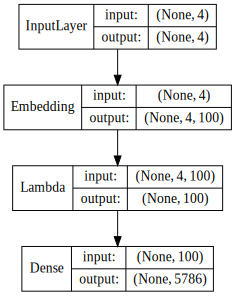

In [29]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=70).create(prog='dot', format='svg'))

#### Train model for 5 epochs

In [30]:
for epoch in range(1, 6):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Epoch: 1 	Loss: 762598.9461057689

Epoch: 2 	Loss: 854755.4304765742

Epoch: 3 	Loss: 924720.2674131382

Epoch: 4 	Loss: 966013.8902234186

Epoch: 5 	Loss: 996225.8138060381



### Get word embeddings

In [31]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(5785, 100)


0     1    2     3    4     5     6     7     8    9     10   11  \
would -0.45 -0.32 0.67 -0.67 0.47 -0.32 -0.13 -0.24 -0.30 0.67 -0.74 0.59   
okay  -0.80 -0.27 0.47 -0.51 0.35 -0.17 -0.51 -1.04 -0.59 0.19 -0.03 0.39   
ok    -1.07 -0.39 0.39 -0.83 0.19 -0.64 -0.35 -0.65 -0.29 0.54 -0.47 0.70   
yes   -0.87 -0.67 0.61 -0.96 0.55 -0.59 -0.44 -0.64 -0.79 0.56 -0.53 0.66   
want  -0.93 -0.27 0.64 -0.76 0.63 -0.29 -0.29 -0.80 -0.68 0.48 -0.65 0.65   

        12    13   14  ...    85    86    87   88    89    90    91    92  \
would 0.52 -0.47 0.64  ... -1.48 -0.13 -0.36 0.42  1.09 -0.65 -0.43 -0.55   
okay  0.48 -0.36 0.57  ... -1.14  0.22 -0.37 0.82 -0.10 -0.56 -0.58 -0.13   
ok    0.65 -0.61 0.86  ... -1.26  0.59 -0.48 0.90  0.31 -0.37 -0.61 -0.54   
yes   0.75 -0.98 0.75  ... -1.22  0.66 -0.41 1.04  0.13 -0.27 -0.43 -0.60   
want  0.62 -0.59 0.59  ... -1.37  0.21 -0.55 1.11  0.21 -0.59 -0.78 -0.51   

        93   94    95    96    97   98   99  
would 0.33 0.29 -0.53 -0.86 -0.65 0.86 0.46  
okay  0.40 0.55 -0.74 -0.27 -0.15 0.32 0.77  
ok    0.46 0.59 -0.68 -0.52 -0.34 0.24 0.50  
yes   0.38 0.84 -0.71 -0.62 -0.25 0.52 0.64  
want  0.52 0.95 -0.94 -0.59 -0.17 0.63 0.13  

[5 rows x 100 columns]

#### Build a distance matrix to view the most similar words (contextually)

In [32]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}

similar_words

(5785, 5785)


{'rental': ['airplane', 'bucca', 'money', 'stk', 'win'],
 'pizza': ['food', 'new', 'black', 'got', 'street'],
 'terminator': ['trace', 'restaurante', 'buttons', 'crescent', 'suites'],
 'star': ['birthday', 'american', 'ca', 'town', 'seen'],
 'audi': ['kia', 'mazda', 'mason', 'connected', 'gift'],
 'east': ['plaza', 'hours', 'always', 'drinks', 'e'],
 'korean': ['outdoors', 'burger', 'grille', 'supposed', 'se'],
 'playing': ['cinema', 'located', 'airport', 'downtown', 'mall']}

#### Implementing a word2vec model using a skip-gram neural network architecture

In [33]:
from keras.preprocessing import text

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(doc_lst)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1 
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 5786
Vocabulary Sample: [('like', 1), ('would', 2), ('okay', 3), ('ok', 4), ('yes', 5), ('want', 6), ('pm', 7), ('order', 8), ('tickets', 9), ('please', 10)]


#### Build and View sample skip grams ((word1, word2) -> relevancy)

In [34]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]

# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(feel (771), driving (506)) -> 1
(dont (62), yes (5)) -> 1
(make (30), thinking (159)) -> 0
(phone (67), seen (401)) -> 1
(say (342), chevy (1099)) -> 1
(yes (5), theyll (858)) -> 1
(driving (506), tires (1683)) -> 1
(asked (910), yes (5)) -> 1
(garage (3408), service (286)) -> 1
(eightthirty (2422), mastercard (5573)) -> 0


#### Build Skip-gram Deep Network Model

In [35]:
from keras.layers import Concatenate
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
#from keras.models import Sequential
from keras.models import Input
from keras.models import Model

input_1 = Input(shape=(1,))

word_1 = Embedding(vocab_size, embed_size,
                         embeddings_initializer="glorot_uniform",
                         input_length=1)(input_1)
word_2 = Reshape((embed_size, ))(word_1)

input_2 = Input(shape=(1,))

context_1 = Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1)(input_2)
context_2 = Reshape((embed_size, ))(context_1)

merge_1 = Concatenate()([word_2, context_2])
#merge_1 = Concatenate()([input_1, input_2])
output_1 = Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid")(merge_1)
model = Model(inputs=[input_1,input_2], outputs=output_1)

model.compile(loss="mean_squared_error", optimizer="rmsprop")
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       578600      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 100)       578600      input_2[0][0]                    
____________________________________________________________________________________________

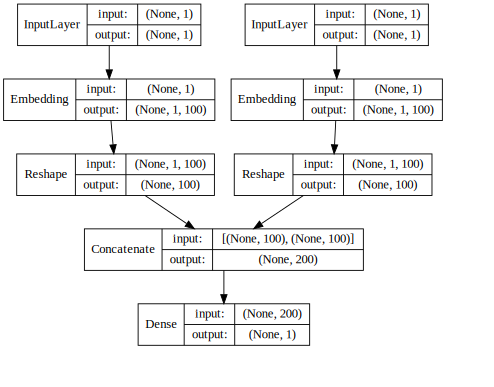

In [36]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=65).create(prog='dot', format='svg'))

#### Train the model for 5 epochs

In [37]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 130.48230735957623
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 113.14199943095446
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 111.11286574229598
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 110.00584302842617
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 109.2732181251049


#### Get word embeddings

In [38]:
merge_layer = model.layers[0]
word_model = model.layers[1]
word_embed_layer = model.layers[2]

weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
pd.DataFrame(weights, index=id2word.values()).head()

(5785, 100)


0    1     2    3     4     5     6    7     8     9    10    11  \
like  0.02 0.04 -0.05 0.04 -0.04 -0.05  0.04 0.06 -0.04 -0.06 0.04 -0.02   
would 0.01 0.01 -0.03 0.05 -0.03 -0.03  0.02 0.02 -0.02 -0.05 0.02 -0.03   
okay  0.03 0.06 -0.06 0.05 -0.02 -0.02  0.01 0.02 -0.03 -0.02 0.01 -0.04   
ok    0.02 0.03 -0.03 0.01 -0.04 -0.06  0.04 0.05 -0.01 -0.02 0.04 -0.03   
yes   0.05 0.02 -0.04 0.01 -0.01 -0.02 -0.00 0.04 -0.02 -0.03 0.01 -0.06   

         12    13    14  ...    85   86   87    88    89   90    91    92  \
like  -0.04 -0.05 -0.02  ...  0.02 0.05 0.05 -0.01 -0.01 0.06 -0.03 -0.02   
would -0.05 -0.00 -0.04  ... -0.00 0.01 0.01 -0.02 -0.05 0.00 -0.03 -0.03   
okay  -0.04 -0.05 -0.00  ...  0.04 0.01 0.03 -0.01 -0.01 0.06 -0.05 -0.04   
ok    -0.04 -0.05 -0.04  ...  0.03 0.06 0.02 -0.02 -0.02 0.05 -0.00 -0.06   
yes   -0.03 -0.06 -0.02  ...  0.02 0.01 0.06 -0.04 -0.00 0.02 -0.02 -0.06   

         93   94    95   96    97   98    99  
like  -0.02 0.03  0.02 0.03 -0.02 0.04 -0.01  
would -0.04 0.04 -0.00 0.01 -0.01 0.06 -0.02  
okay  -0.03 0.01  0.05 0.04  0.00 0.02 -0.04  
ok    -0.01 0.01  0.02 0.02 -0.03 0.02 -0.05  
yes   -0.03 0.04  0.03 0.05 -0.05 0.03 -0.01  

[5 rows x 100 columns]

#### Build a distance matrix to view the most similar words (contextually)

In [39]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}

similar_words

(5785, 5785)


{'rental': ['pizzas', 'vegetables', 'orlando', 'gluten', 'favorites'],
 'pizza': ['pepper', 'dolce', 'swing', 'smokehouse', 'early'],
 'terminator': ['kings', 'reston', 'apopka', 'limitless', 'closing'],
 'star': ['beautiful', 'saying', 'sharp', 'theyve', 'foothill'],
 'audi': ['nicer', 'seeing', 'roasted', 'manager', 'diet'],
 'east': ['money', 'rpx', 'alone', 'de', 'recommendation'],
 'korean': ['hawaiian', 'topping', 'drive', 'lol', 'choose'],
 'playing': ['details', 'remind', 'humor', 'delay', 'subs']}

#### Visualize word embeddings

Total words: 48 	Word Embedding shapes: (48, 100)


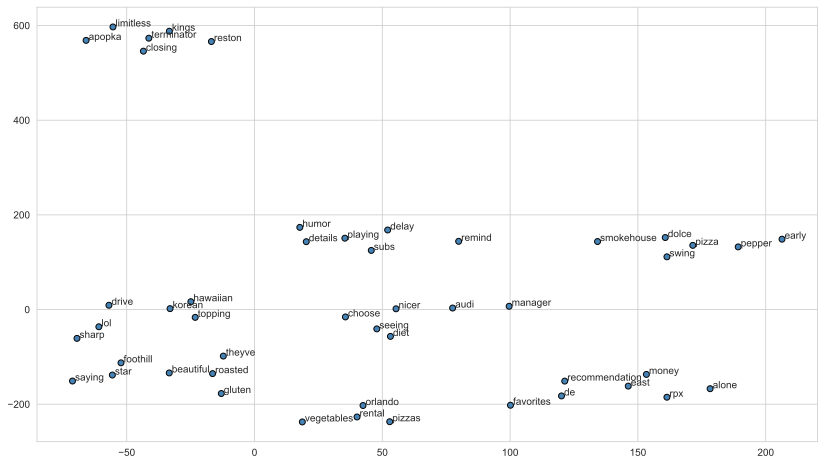

In [40]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx-1] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Leveraging gensim for building a word2vec model

In [42]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in doc_lst]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['trim', 'challenger', 'lauren', 'sxt', 'matt'],
 'pizza': ['hut', 'sausage', 'large', 'toppings', 'pan'],
 'terminator': ['abyss', 'judgment', 'sigourney', 'weaver', 'vi'],
 'star': ['wars', 'jedi', 'series', 'vi', 'rating'],
 'audi': ['appoint', 'powers', 'ken', 'jones', 'q'],
 'east': ['richardson', 'uncle', 'awang', 'crystal', 'papa'],
 'korean': ['countryside', 'bbgo', 'pinellas', 'lauderhill', 'pig'],
 'playing': ['theaters', 'flexible', 'shows', 'billings', 'rethink']}

#### Visualizing word embeddings

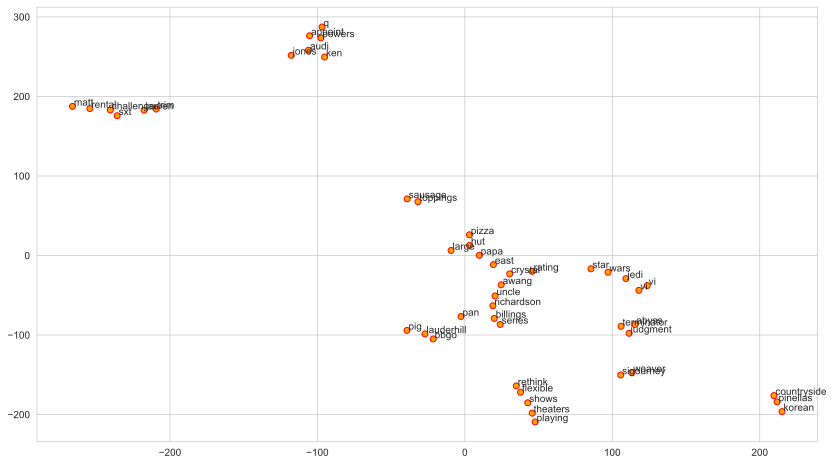

In [43]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our sample corpus

In [44]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in doc_lst]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

#### Visualize word embeddings

In [45]:
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Sample word embedding

In [46]:
w2v_model.wv['sky']

array([ 0.13863125, -1.9728951 ,  0.13722275,  1.3456321 , -1.0225046 ,
        0.20253977, -0.19561672,  2.4790606 , -0.03430973, -0.5712002 ],
      dtype=float32)

#### Build framework for getting document level embeddings

In [48]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [49]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

0     1     2     3     4     5     6     7     8     9
0    0.72  1.32 -0.76 -0.11  0.87 -1.93  0.79 -0.11 -2.17 -1.38
1   -0.06  1.76 -0.77  0.29  0.78 -1.65  0.67 -0.36 -2.90 -0.87
2    1.69 -0.08 -1.29 -0.16 -1.20  4.09  2.36  2.11 -1.32 -2.62
3   -0.28  0.27  0.16 -0.70  2.24  0.91  0.00  0.16 -1.47 -0.61
4    2.68  0.51 -1.66 -1.05 -0.07  1.46 -0.41 -1.46 -0.94  2.61
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
995 -0.21 -0.28 -2.31 -2.88  0.22  0.69 -1.93 -1.57  0.18  2.60
996 -0.76 -0.30  0.28 -0.41  2.93  1.16 -0.34  1.17 -1.52 -0.80
997 -0.49  1.11 -1.25  0.99 -0.33  0.62 -0.38  0.31 -2.13  0.20
998  0.62 -0.07 -0.97 -0.23  1.31  3.39  0.31 -1.24 -1.46 -1.40
999 -1.35  0.35  0.05 -1.78  2.34  2.33  0.81  2.53 -1.05 -1.92

[1000 rows x 10 columns]

#### Clustering with word embeddings

In [50]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

...   
1706                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        I want to request a uber ride very well, from where to where? royal botanical garden to my current hotel in Sydney I can do that for you, anything else I want uber x and the time in 10 minutes I just found out they do not have uber x, only uber xl that is fine should we use the account we already have with them yes how have your stay so far in Sydney very well the estimated fair is $10 australian dollars that is fin your ride is on the way how soon you can check the status on your phone great, thank you you are welcome    
1708                                                                                                                                                                                                                                                                                                                                                                                                            I need to order a ride from Uber. Where do you need that ride sent to? The Reg Lenna Center for the Arts in downtown Jamestown, NY. And where are you traveling to? The Athenaeum Hotel at Chautauqua Institution What type of car? There are six in our party so we need an Uber XL. Unfortunately there are no XL vehicles available. What type of vehicles are available? The only available rides at the moment are Uber Xes, which carry up to 4 passengers. How much are the Uber Xes going for? The estimated fare to your hotel is $25. Can you order us 2 Uber Xes. That would be enough for our party. Yes, that would be around $50 total for both rides. That's fine. We are in a hurry to get back to the hotel. What is the estimated wait time. Both cars should be there in less than 10 minutes. OK, go ahead and set that up for us please. Ordering two Uber X vehicles to meet you at the Reg Lenna Center for the Arts and take you to the Atheneum Hotel in Chautauqua Institution. Thank you Expect your cars to arrive in under 10 minutes. The details of this transaction are being sent to your mobile phone.    
1709                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Hi! Can you order an Uber, please? What are the pick

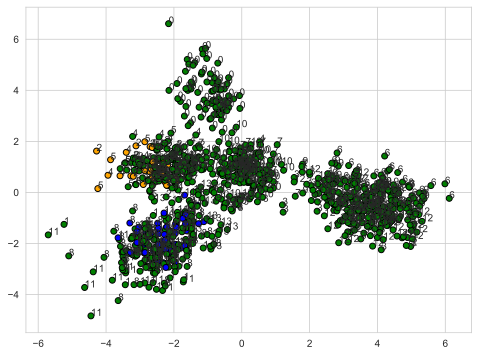

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

#### GloVe Embeddings with spaCy

In [53]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [55]:
unique_words = list(set([word for sublist in [doc.split() for doc in doc_lst] for word in sublist]))

word_glove_vectors = np.array([nlp(word).vector for word in unique_words])
pd.DataFrame(word_glove_vectors, index=unique_words)

0     1     2     3     4     5     6     7     8     9     10   \
crazy      -0.37 -0.10 -0.14 -0.12 -0.03  0.27  0.13  0.03  0.23  1.85 -0.30   
futuristic  0.70 -0.55  0.10 -0.43  0.09  0.08  0.07  0.06 -0.06  0.55  0.28   
sort       -0.07  0.02 -0.10  0.23  0.00  0.19 -0.08 -0.34  0.07  2.22 -0.14   
escape      0.53 -0.22 -0.05  0.00  0.03 -0.04 -0.08  0.23  0.07  2.35 -0.24   
machiato    0.15 -0.46 -0.26  1.06  0.18 -0.32 -0.04  0.40  0.15 -1.04  0.04   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
oldtown     0.78 -0.63 -0.17  0.51  0.37  0.27 -0.09  0.28  0.79 -1.19 -0.38   
pittsburgh  0.11 -0.12 -0.31 -0.35  0.61 -0.00  0.19  0.25  0.75  0.52 -1.08   
kobe       -0.78 -0.45  0.92 -0.71  0.87  0.05  0.16 -0.23  0.33 -0.03 -0.88   
pastry      0.69 -0.10  0.33 -0.31  0.08 -0.24  0.12  0.36  0.15  0.89 -0.02   
roseville  -0.36  0.27  0.18 -0.21  0.62  0.08 -0.45 -0.19  0.80 -0.14 -0.25   

             11    12    13    14   ...   285   286   287   288   289   290  \
crazy       0.02 -0.06  0.00 -0.11  ...  0.29  0.27 -0.14  0.09  0.08 -0.17   
futuristic -0.15 -0.01  0.44  0.18  ... -0.30  0.02 -0.16 -0.51 -0.33 -0.53   
sort       -0.01  0.10 -0.17 -0.08  ... -0.16 -0.18 -0.27 -0.01 -0.32 -0.15   
escape     -0.28 -0.36  0.44 -0.25  ... -0.36  0.20  0.26  0.36 -0.15  0.06   
machiato   -0.33 -0.67 -0.55  0.64  ... -0.66 -0.07  0.29 -1.43  0.43  0.66   
...          ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   
oldtown    -0.83 -0.35  0.01 -0.44  ...  0.28  0.30 -0.17 -0.25  0.48  0.79   
pittsburgh -0.26  0.28 -0.04 -0.22  ...  0.14  0.17  0.32  0.16  0.34  0.35   
kobe        0.05 -0.44  0.18  0.36  ...  0.62 -0.13  0.54 -0.19 -0.19  1.29   
pastry      0.43 -0.22  0.12  0.18  ...  0.12  0.44 -0.07 -0.35 -0.15  1.19   
roseville  -0.04  0.08 -0.36 -0.28  ...  0.26  0.58  0.64 -0.58 -0.12 -0.21   

             291   292   293   294   295   296   297   298   299  
crazy      -0.20  0.14  0.06 -0.01  0.31 -0.02  0.02  0.30  0.03  
futuristic  0.03  0.49  0.28 -0.58  0.29  0.11  0.55 -0.04  0.50  
sort        0.06  0.07  0.14  0.06  0.35 -0.05 -0.00  0.04  0.23  
escape      0.28 -0.29 -0.09  0.11  0.13 -0.09  0.62 -0.19 -0.14  
machiato   -0.24 -0.38 -0.54  0.46  0.32  0.04 -0.65  0.38  0.09  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...  
oldtown    -0.30 -0.03 -0.60 -0.07  0.54  0.30  0.66 -0.90 -0.27  
pittsburgh -0.26 -0.10  0.38 -0.02 -0.41 -0.01 -0.03 -0.40  0.41  
kobe        0.48 -0.69 -0.19  0.89 -0.35 -0.39 -0.23  0.22  0.27  
pastry      0.78 -0.04 -0.26 -0.60  0.05  0.80 -0.54  0.06  0.62  
roseville   0.71 -0.12 -0.07 -0.38 -0.06 -0.16 -0.74 -0.28  0.19  

[5785 rows x 300 columns]

In [56]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_glove_vectors)
labels = unique_words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Cluster documents with GloVe Embeddings

In [57]:
from sklearn.cluster import KMeans

doc_glove_vectors = np.array([nlp(str(doc)).vector for doc in doc_lst])

km = KMeans(n_clusters=3, random_state=0)
km.fit_transform(doc_glove_vectors)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

...   
1706                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        I want to request a uber ride very well, from where to where? royal botanical garden to my current hotel in Sydney I can do that for you, anything else I want uber x and the time in 10 minutes I just found out they do not have uber x, only uber xl that is fine should we use the account we already have with them yes how have your stay so far in Sydney very well the estimated fair is $10 australian dollars that is fin your ride is on the way how soon you can check the status on your phone great, thank you you are welcome    
1708                                                                                                                                                                                                                                                                                                                                                                                                            I need to order a ride from Uber. Where do you need that ride sent to? The Reg Lenna Center for the Arts in downtown Jamestown, NY. And where are you traveling to? The Athenaeum Hotel at Chautauqua Institution What type of car? There are six in our party so we need an Uber XL. Unfortunately there are no XL vehicles available. What type of vehicles are available? The only available rides at the moment are Uber Xes, which carry up to 4 passengers. How much are the Uber Xes going for? The estimated fare to your hotel is $25. Can you order us 2 Uber Xes. That would be enough for our party. Yes, that would be around $50 total for both rides. That's fine. We are in a hurry to get back to the hotel. What is the estimated wait time. Both cars should be there in less than 10 minutes. OK, go ahead and set that up for us please. Ordering two Uber X vehicles to meet you at the Reg Lenna Center for the Arts and take you to the Atheneum Hotel in Chautauqua Institution. Thank you Expect your cars to arrive in under 10 minutes. The details of this transaction are being sent to your mobile phone.    
1709                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Hi! Can you order an Uber, please? What are the pick

#### Leveraging gensim for building a FastText model

In [58]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in doc_lst]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [59]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['drama', 'moment', 'indianapolis', 'wars', 'reserve'],
 'pizza': ['pepperoni', 'pizzas', 'cheese', 'sausage', 'crust'],
 'terminator': ['terminal', 'airport', 'jfk', 'international', 'washington'],
 'star': ['wars', 'born', 'recommendations', 'recommended', 'cameron'],
 'audi': ['costs', 'austin', 'general', 'cinema', 'fee'],
 'east': ['broadway', 'tampa', 'broad', 'chicago', 'pies'],
 'korean': ['belt', 'anywhere', 'blvd', 'grill', 'bbq'],
 'playing': ['tickets', 'movie', 'showing', 'theater', 'pet']}

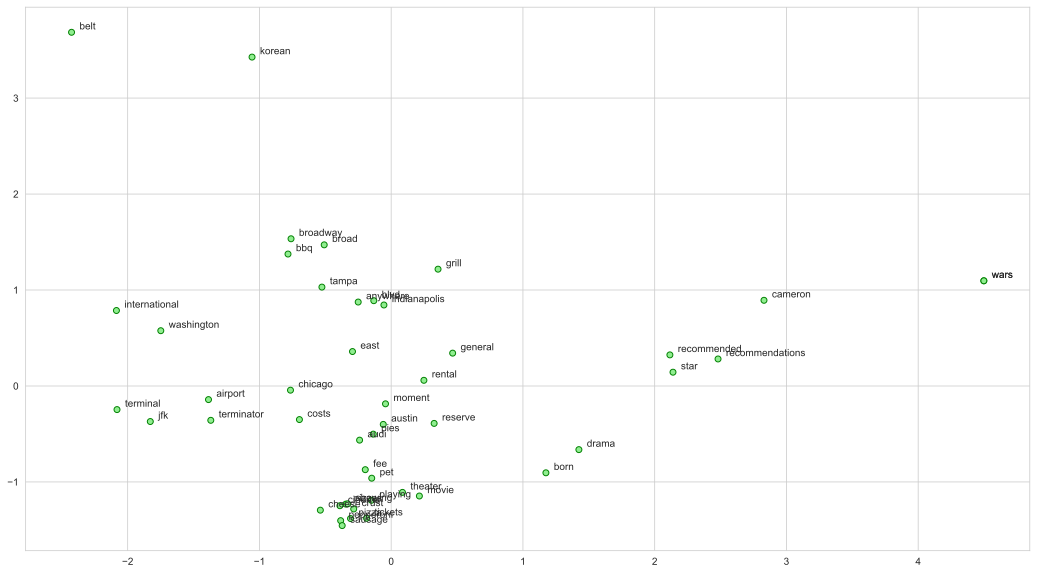

In [60]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [61]:
ft_model.wv['rental']

array([-0.159931  , -0.4715582 ,  0.20080853, -0.37942922,  0.32679608,
       -0.5193822 ,  0.03108732,  0.13750559, -0.19606566,  0.12210814,
       -0.16109028,  0.08520142, -0.4555036 , -0.04613556,  0.41115522,
        0.00039929, -0.33218724, -0.1443286 ,  0.38980013, -0.01459857,
        0.42017284, -0.12342175, -0.03493973, -0.18944828, -0.16120075,
        0.06246398, -0.20994098,  0.38306248, -0.12644786, -0.0828645 ,
       -0.11812786,  0.0071423 ,  0.28318402,  0.35417414,  0.07532656,
       -0.32349357, -0.21564   ,  0.49176434,  0.05538502,  0.15074153,
        0.13661136, -0.10369486,  0.30871505, -0.18018603, -0.02858236,
       -0.20835625, -0.12001361, -0.22068554,  0.41642517, -0.6025088 ,
        0.4114399 ,  0.4526229 ,  0.56534636,  0.26406825,  0.02590969,
       -0.00972404, -0.04670722,  0.11215308,  0.11989847, -0.19483012,
       -0.5224256 , -0.132594  ,  0.0243189 , -0.08337057,  0.1091096 ,
        0.3639107 , -0.3165195 ,  0.38650432,  0.28302038,  0.22

In [63]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.20476826
0.7579293


In [65]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pies
